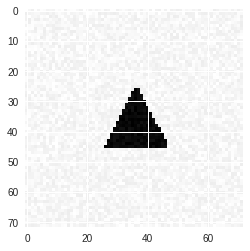

In [140]:
import matplotlib.pyplot as plt
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    from keras.utils import np_utils
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    from keras.utils import np_utils
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]



 ## Simple Classification
 
 Build and train a linear classifier in Keras to classify a image into one of the three possible categories (i.e.  rectangle, disk, triangle).  Try using the stochastic gradient descent optimizer, then the Adam optimizer
 

In [106]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

[X_test, Y_test] = generate_dataset_classification(500, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


I've added some test set to check that the convergence was real and it was not only overfitting.

In [0]:
#Let's binnerize the target since it's a multi-label classificiation task
from keras.utils import np_utils

y_train= np_utils.to_categorical(Y_train, 3)
y_test= np_utils.to_categorical(Y_test, 3)


In [0]:
#Let's build a linear model
from keras.models import Sequential
from keras.layers import Dense, Activation

model_sgd = Sequential([Dense(3, input_shape=(X_train.shape[1],)),
                    Activation('sigmoid')])

#Let's choose the optimizer

#We'll start with the SGD. We'll look at the Adam Optimizer later
from keras.optimizers import SGD

#Surprisingly a very low value of learnign rate is needed to converge
sgd= SGD(lr=0.0002, decay=0.001, momentum=0.9)

model_sgd.compile(loss='categorical_crossentropy', optimizer=sgd, 
                  metrics=['accuracy'])

results = model_sgd.fit(X_train, y_train, epochs=2000, batch_size=128, 
                        verbose=0, validation_data=[X_test, y_test])

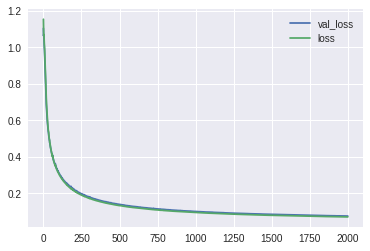

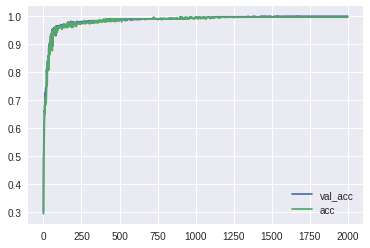

In [0]:
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(results.history["loss"], label="loss")
plt.legend()
plt.show()

plt.plot(results.history["val_acc"], label="val_acc")
plt.plot(results.history["acc"], label="acc")
plt.legend()
plt.show()

In [0]:
x_test = generate_a_disk()/255.
x_test = x_test.reshape(1, x_test.shape[0])
model_sgd.predict(x_test)

array([[3.0200099e-04, 9.4638439e-03, 3.3262431e-06]], dtype=float32)

We can see that even if the scores are not high the index 1 is by far the highest value. Which is the disk one.

In [0]:
#Let's build a linear model
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential([Dense(3, input_shape=(X_train.shape[1],)),
                    Activation('sigmoid')])

#Let's choose the optimizer
from keras.optimizers import Adam
adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, 
            decay=1e-6, amsgrad=False)
#We'll look at the Adam Optimizer later
model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics=['accuracy'])


results = model.fit(X_train, y_train, epochs=1000, batch_size=128, 
                        verbose=0, validation_data=[X_test, y_test])

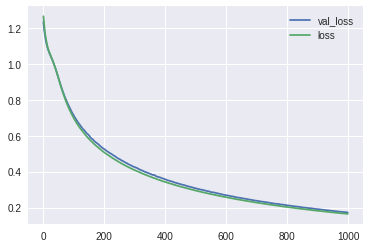

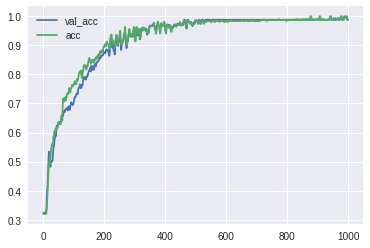

In [125]:
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(results.history["loss"], label="loss")
plt.legend()
plt.show()

plt.plot(results.history["val_acc"], label="val_acc")
plt.plot(results.history["acc"], label="acc")
plt.legend()
plt.show()

## Visualization of the Solution

Visualize the 3 columns as images.

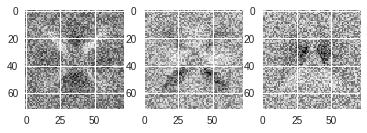

In [0]:
fig, ax = plt.subplots(1,3)

for i in range(3):
    ax[i].imshow(model_sgd.get_weights()[0][:,i].reshape(72,72))
plt.show()

We can see that a pattern is emerging but the images are blury. 

##  A More Difficult Classification Problem

Train a convolutional (not-to-)deep network on this new dataset.  What is the value of the loss
function on this test set when using your deep network?

In [141]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [0]:
X_train = X_train.reshape(-1,72,72,1)
X_test = X_test.reshape(-1,72,72,1)


y_train= np_utils.to_categorical(Y_train, 3)
y_test= np_utils.to_categorical(Y_test, 3)

In [143]:
X_train.shape[1:]

(72, 72, 1)

In [0]:
from keras.layers import Flatten
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dropout


model = Sequential()
model.add(Conv2D(16, (5,5), strides=(1,1), padding='valid', 
           activation='relu', input_shape=(72, 72,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

print(model.summary())

#Let's choose the optimizer
from keras.optimizers import Adam
adam = Adam(decay=1e-6)

#We'll look at the Adam Optimizer later
model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics=['accuracy'])


results = model.fit(X_train, y_train,
                    epochs=2000, batch_size=128, 
                    verbose=0, 
                    validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 68, 68, 16)        416       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 34, 34, 16)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 34, 34, 16)        0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 18496)             0         
_________________________________________________________________
dense_60 (Dense)             (None, 3)                 55491     
Total params: 55,907
Trainable params: 55,907
Non-trainable params: 0
_________________________________________________________________
None


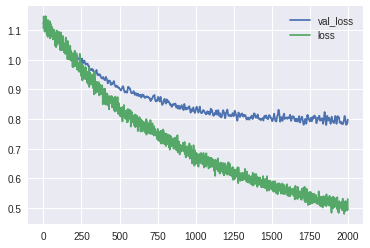

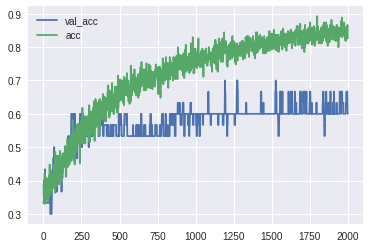

In [149]:
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(results.history["loss"], label="loss")
plt.legend()
plt.show()

plt.plot(results.history["val_acc"], label="val_acc")
plt.plot(results.history["acc"], label="acc")
plt.legend()
plt.show()

In [150]:
model.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 211us/step


[0.6915415517489115, 0.7099999992052713]

##  A Regression Problem

Build and train a regressor on this data. Evaluate your solution on the test set

In [0]:
def reorder_y(Y):
  Y_ = np.zeros_like(Y).reshape(-1,3,2)
  for i in range(Y_.shape[0]):
    tmp = Y[i].reshape(3,2)
    Y_[i] = tmp[np.argsort(tmp,axis=0)[:,0],:]
  return Y_.reshape(-1,6)


There is an issue with the Y target. Since the verteces are labeled randomly, it is very hard to predict the order in which they are plot. So we only have to roder them in order to reduce this randomness and have a more predictive model.

In [0]:

[X_train, Y_train] = generate_dataset_regression(3000, 20)
X_train = X_train.reshape(X_train.shape[0], 72, 72, 1)
Y_train_reorder = reorder_y(Y_train)
y_train_reorder = normalize_Y(Y_train)

[X_test, Y_test] = generate_test_set_regression()
X_test = X_test.reshape(X_test.shape[0], 72, 72, 1)
Y_test_reorder = reorder_y(Y_test)
y_test_reorder = normalize_Y(Y_test)


Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2

In [0]:
#Let's build a CNN
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Conv2D, MaxPooling2D

model = Sequential()

model.add(Conv2D(16, (3,3), padding="valid", activation='relu',input_shape=(72, 72,1)) )
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(128, (3,3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

from keras.layers import Flatten
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(6))

#Let's choose the optimizer
from keras.optimizers import Adam
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.99, epsilon=None, decay=1e-4, amsgrad=False)

#We'll look at the Adam Optimizer later
model.compile(loss='mean_absolute_error', optimizer=adam)


history = model.fit(X_train.reshape(-1,72,72,1), Y_train_reorder, 
                    epochs=500, verbose=2, batch_size=128, 
                    validation_data=[X_test, Y_test_reorder])

Using TensorFlow backend.


Train on 3000 samples, validate on 300 samples
Epoch 1/500
 - 3s - loss: 0.2466 - val_loss: 0.1911
Epoch 2/500
 - 1s - loss: 0.1661 - val_loss: 0.1429
Epoch 3/500
 - 1s - loss: 0.1305 - val_loss: 0.1217
Epoch 4/500
 - 1s - loss: 0.1107 - val_loss: 0.1040
Epoch 5/500
 - 1s - loss: 0.0978 - val_loss: 0.1025
Epoch 6/500
 - 1s - loss: 0.0904 - val_loss: 0.0922
Epoch 7/500
 - 1s - loss: 0.0812 - val_loss: 0.0854
Epoch 8/500
 - 1s - loss: 0.0761 - val_loss: 0.0771
Epoch 9/500
 - 1s - loss: 0.0709 - val_loss: 0.0734
Epoch 10/500
 - 1s - loss: 0.0691 - val_loss: 0.0731
Epoch 11/500
 - 1s - loss: 0.0645 - val_loss: 0.0679
Epoch 12/500
 - 1s - loss: 0.0620 - val_loss: 0.0674
Epoch 13/500
 - 1s - loss: 0.0595 - val_loss: 0.0624
Epoch 14/500
 - 1s - loss: 0.0573 - val_loss: 0.0636
Epoch 15/500
 - 1s - loss: 0.0565 - val_loss: 0.0607
Epoch 16/500
 - 1s - loss: 0.0525 - val_loss: 0.0568
Epoch 17/500
 - 1s - loss: 0.0504 - val_loss: 0.0569
Epoch 18/500
 - 1s - loss: 0.0500 - val_loss: 0.0591
Epoch 19

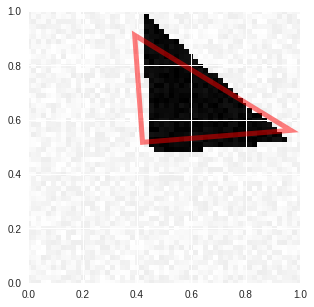

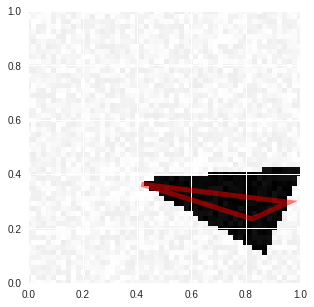

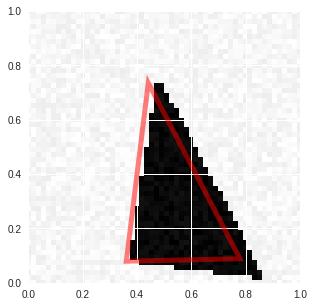

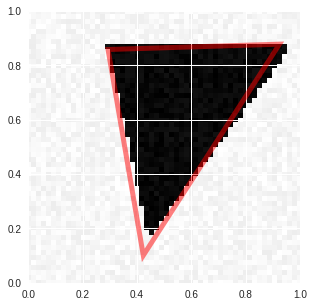

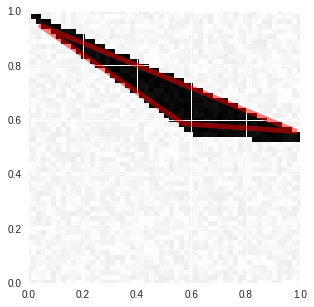

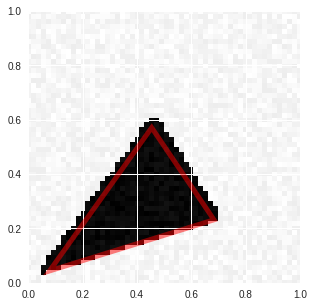

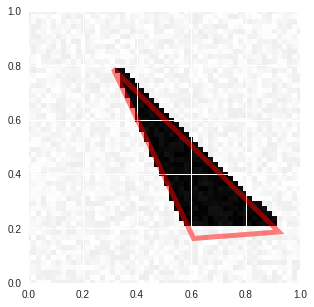

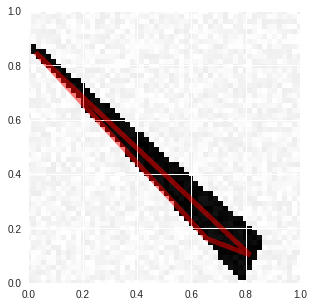

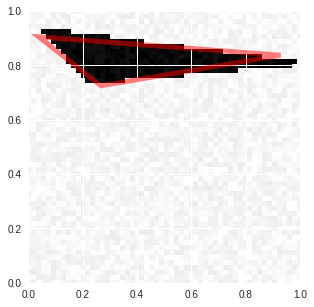

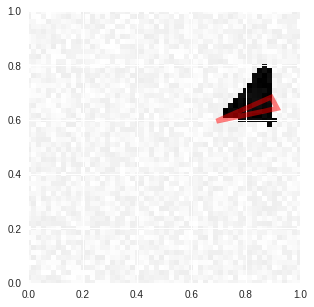

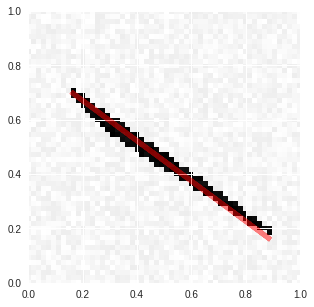

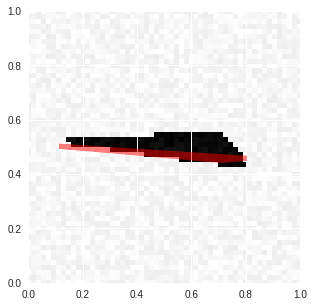

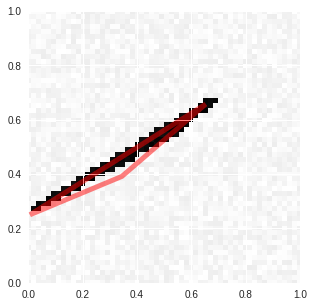

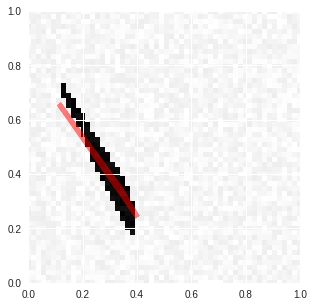

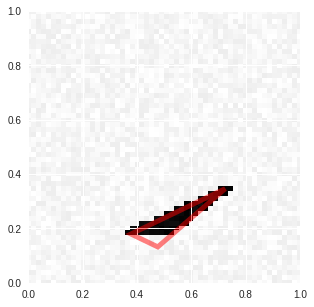

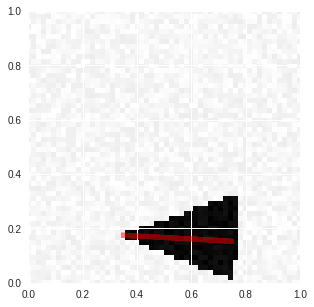

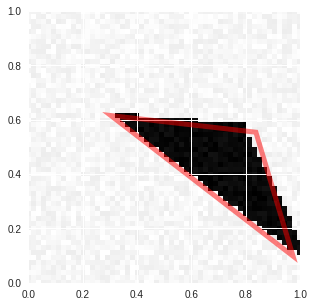

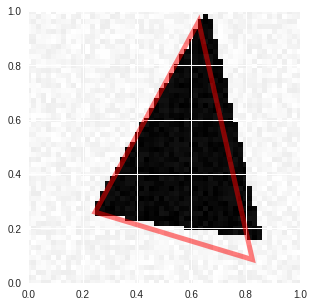

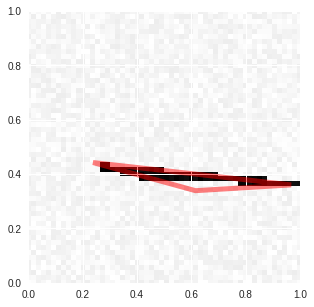

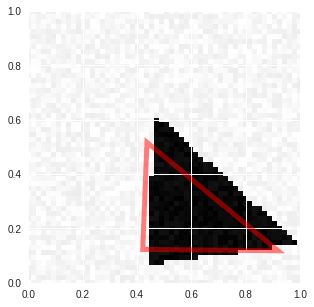

In [0]:
for i in np.random.randint(X_test.shape[0],size=20):
  visualize_prediction(X_test[i], model.predict(X_test[i].reshape(-1,72,72,1)))
  plt.show()

##  Image Denoising

In [0]:

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata_random = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata_random, imdata
  

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    return generate_a_drawing(figsize, U, V, noise)



def generate_dataset_denoising(nb_samples, noise=0.0, free_location=False):
    from keras.utils import np_utils
    # Getting im_size:
    im_size = generate_a_rectangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        category = np.random.randint(3)
        if category == 0:
            X[i],Y[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i],Y[i] = generate_a_disk(noise, free_location)
        else:
            X[i],Y[i] = generate_a_triangle(noise, free_location)
    X = (X + noise) / (255 + 2 * noise)
    Y = (Y + noise) / (255 + 2 * noise)
    return [X, Y]


In [0]:
X_train, Y_train = generate_dataset_denoising(3000,90,True)

Creating data:


In [0]:
#Let's build a CNN
from keras.models import Model
from keras.layers import Dense, Activation, Input, concatenate
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D


def U_Net(inputs):
    #encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1a = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1a) 
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2a = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2) 
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2a) 
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3a = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3a) 
    
    
    #decoder
    up4 = UpSampling2D((2,2))(pool3)
    conv4 = Conv2D(256, (2, 2), activation='relu', padding='same')(up4)
    conv4a = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4b = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4a)
    
    up5 = UpSampling2D((2,2))(conv4b)
    conv5 = Conv2D(128, (2, 2), activation='relu', padding='same')(up5)
    merge5 = concatenate([conv2a,conv5],axis=3)
    conv5a = Conv2D(128, (3, 3), activation='relu', padding='same')(merge5)
    conv5b = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5a)
    
    
    up6 = UpSampling2D((2,2))(conv5a)
    conv6 = Conv2D(64, (2, 2), activation='relu', padding='same')(up6)
    merge6 = concatenate([conv1a,conv6],axis=3)
    conv6a = Conv2D(64, (3, 3), activation='relu', padding='same')(merge6)
    conv6b = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6a)
    decoded = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(conv6b) 

    return decoded



inputs = Input(shape=(72, 72, 1))
model = Model(input=inputs, 
              output=U_Net(inputs))
  
#Let's choose the optimizer
from keras.optimizers import Adam
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.99, 
            epsilon=None, 
            decay=0.01, amsgrad=False)

#We'll look at the Adam Optimizer later
model.compile(loss='mean_absolute_error', optimizer=adam)


history = model.fit(X_train.reshape(-1,72,72,1), Y_train.reshape(-1,72,72,1), 
                    epochs=50, batch_size=128, validation_split=0.1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Train on 2700 samples, validate on 300 samples
Epoch 1/50
2700/2700 [==============================] - 29s 11ms/step - loss: 0.0954 - val_loss: 0.0606
Epoch 2/50
2700/2700 [==============================] - 20s 8ms/step - loss: 0.0527 - val_loss: 0.0458
Epoch 3/50
2700/2700 [==============================] - 20s 8ms/step - loss: 0.0423 - val_loss: 0.0394
Epoch 4/50
2700/2700 [==============================] - 20s 8ms/step - loss: 0.0298 - val_loss: 0.0120
Epoch 5/50
2700/2700 [==============================] - 20s 8ms/step - loss: 0.0095 - val_loss: 0.0076
Epoch 6/50
2700/2700 [==============================] - 20s 8ms/step - loss: 0.0069 - val_loss: 0.0061
Epoch 7/50
2700/2700 [==============================] - 20s 8ms/step - loss: 0.0058 - val_loss: 0.0056
Epoch 8/50
2700/2700 [==============================] - 20s 8ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 9/50
2700/2700 [==============================] - 20s 8ms/step - loss: 0.0048 - val_loss: 0.0044
Epoch 10/50
2700/2700 [==

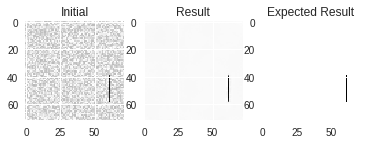

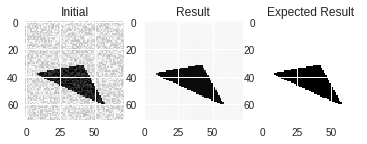

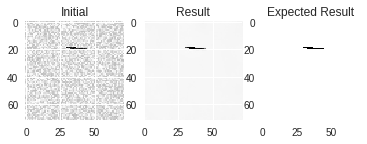

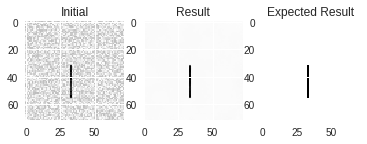

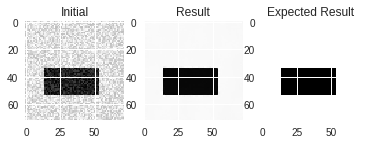

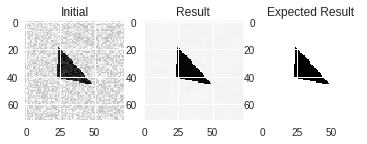

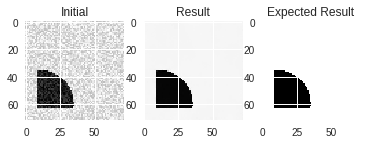

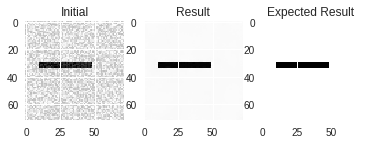

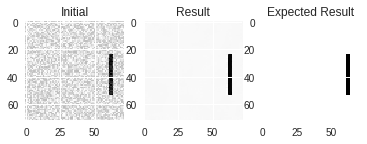

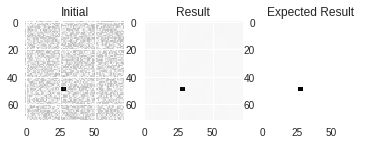

In [0]:

for i in range(10):
  fig, ax = plt.subplots(1, 3)
  ax[0].set_title('Initial')
  ax[0].imshow(X_train[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

  ax[1].set_title('Result')
  ax[1].imshow(model.predict(X_train[i].reshape(1, 72,72,1)).reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

  ax[2].set_title('Expected Result')
  ax[2].imshow(Y_train[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
  plt.show()